In [15]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')

import os, sys, shutil
sys.path.append("..")

from lammpsrun import *
from PBSJobSubmissionScript import PBS_Submitter, qstat_monitor
from utility_scripts import *

from ase import Atoms, units
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.io.trajectory import Trajectory
from ase.io import write, read
from ase.build import molecule, bcc110, bcc111
from ase.spacegroup import crystal
from ase.data import atomic_numbers, atomic_names, atomic_masses, covalent_radii

cx1_out = r"/rds/general/user/yx6015/home/cx1_out/"
ephemeral = r"/rds/general/user/yx6015/ephemeral/"
sim_path = r"/rds/general/user/yx6015/home/LAMMPS_Simulation/HPC_Jupyter/"
print(cx1_out + '\n' + sim_path)
potential = "fe_o_water_fe_o_c_full_water.reax"
convert_scripts_dir = r"/rds/general/user/yx6015/home/LAMMPS_Simulation/HPC_Scripts/"

/rds/general/user/yx6015/home/cx1_out/
/rds/general/user/yx6015/home/LAMMPS_Simulation/HPC_Jupyter/


# Building the box

## Creating the simulation box particles

In [2]:
aq_thickness = 50
n_co2 = 50

In [3]:
Fe_bcc111_l32 = bcc111('Fe', a=2.870, size=(8,8,16), orthogonal=True, vacuum=1)
Fe_bcc111_l32.set_cell(Fe_bcc111_l32.get_cell() + np.array([[0,0,0],[0,0,0],[0,0,aq_thickness]]))

In [4]:
aq_cell_l100 = np.array(list(Fe_bcc111_l32.get_cell_lengths_and_angles()[:2]) + [aq_thickness])
H2O_l100 = create_water_region(aq_cell_l100*0.99)

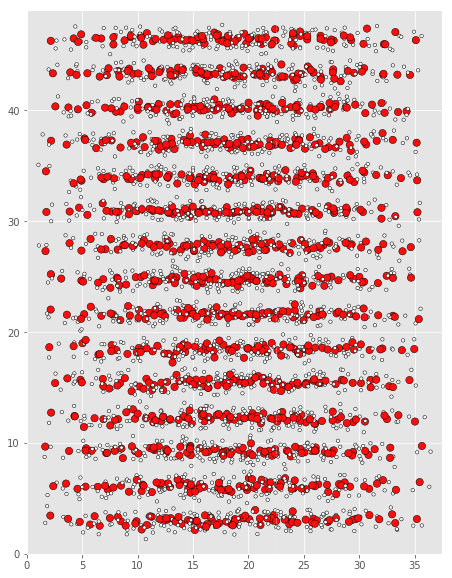

In [5]:
plt.figure(figsize=(18, 10))
plot_atoms(H2O_l100, radii=0.5, rotation=('90x,60y,0z'), show_unit_cell=True)
#Fe_bcc111_l40_aq.write(sim_path + "fe_aq/Fe_bcc111_l40_aq.extxyz")
plt.show()

In [5]:
aq_dir = os.path.join(sim_path, "water")
aq_efields = np.arange(0.0, 0.7, 0.3) # V/A = 100MV/cm => 0 MV/cm to 45 MV/cm
aq_efields_names = ['Aq_efield_{0:.0f}MVcm'.format(x*100) for x in aq_efields]
aq_efields_names

['Aq_efield_0MVcm', 'Aq_efield_30MVcm', 'Aq_efield_60MVcm']

In [6]:
H2O_l100.set_pbc([True, True, False])

In [20]:
for label, efield in zip(aq_efields_names, aq_efields):
    calc = reaxff_params_generator(H2O_l100, label,
                                   write_input=True,
                                   input_fd=aq_dir,
                                   run=100000,
                                   timestep=0.1,
                                   fix=["all_nvt all nvt temp 300.0 300.0 100.0",
                                        "qeq_reaxc all qeq/reax 1 0.0 10.0 1e-6 reax/c",
                                        "elec all efield 0.0 0.0 {0:.2f}".format(efield),
                                        "reax_info all reax/c/bonds 10 bonds.tatb", # every fs
                                        "zwalls all wall/reflect zlo EDGE zhi EDGE",],
                                   velocity=["all create 300.0 1050027 rot yes mom yes dist gaussian"],
                                   potential=potential)

In [21]:
aq_commands = [["mpiexec lmp_intel_cpu_intelmpi -sf omp -pk omp 8 -in {0}.lammpsin -screen none\n".format(x),
                "python convert_script_nocopy_fast.py {} {}".format(x, x+'.lammpstrj')] for x in aq_efields_names]
aq_source_files = [['$HOME/LAMMPS_Simulation/potentials/{0}'.format(potential),
                    '$PBS_O_WORKDIR/{}.*'.format(x),
                    os.path.join(convert_scripts_dir, "convert_script_nocopy_fast.py"),
                    os.path.join(convert_scripts_dir, "lammpsrun.py")] for x in aq_efields_names]

In [22]:
aq_PBS = PBS_Submitter(job_names=aq_efields_names,
                       job_commands=aq_commands,
                       modules=["mpi", "lammps/11Aug17", "intel-suite/2017", "anaconda3/personal"],
                       walltime="24:00:00",
                       proc_nodes=1,
                       proc_cpus=32,
                       proc_mpiprocs=4,
                       proc_threads=8,
                       memory=48,
                       source_files=aq_source_files)

In [23]:
os.chdir(aq_dir)
aq_out, aq_err = aq_PBS.run()
os.chdir(sim_path)
print(aq_out, aq_efields_names)

['2479808.cx1', '2479809.cx1', '2479810.cx1'] ['Aq_efield_0MVcm', 'Aq_efield_30MVcm', 'Aq_efield_60MVcm']


In [ ]:
# Move all the log and error files over

for outfile, job_out in zip(aq_efields_names, aq_out):
    shutil.move(os.path.join(aq_dir, outfile + ".err"), os.path.join(ephemeral, job_out))
    shutil.move(os.path.join(aq_dir, outfile + ".log"), os.path.join(ephemeral, job_out))